In [ ]:
! pip install pyxdf
! pip install gdown

In [ ]:
import urllib.request
import numpy as np
import scipy
import os
import itertools
from scipy.io import wavfile
from joblib import Parallel, delayed
import matplotlib.pyplot as plt
import pyxdf
from scipy.interpolate import interp1d
from scipy.signal import butter, sosfilt, sosfreqz
from scipy.fft import fft, fftfreq
rng = np.random.default_rng(42)
plt.style.use('seaborn')


def butter_highpass(cutoff=5, fs=250, order=4):
  nyq = 0.5 * fs
  normal_cutoff = cutoff / nyq
  sos = butter(order, normal_cutoff, btype='high', output='sos')
  return sos

def butter_bandpass(lowcut=5, highcut=50, fs=250, order=4):
  nyq = 0.5 * fs
  low = lowcut / nyq
  high = highcut / nyq
  sos = butter(order, [low, high], analog=False, btype='band', output='sos')
  return sos

def butter_bandpass_filter(data, lowcut, highcut, fs=250, axis=0, order=4):
  sos = butter_bandpass(lowcut, highcut, fs, order)
  y = sosfilt(sos, data, axis)
  return y

def butter_highpass_filter(data, cutoff, fs=250, axis=0, order=4):
  sos = butter_highpass(cutoff, fs, order)
  y = sosfilt(sos, data, axis)
  return y

def write_file(file_content, file_path, flag='w+'):
  with open(file_path, flag) as fp:
    fp.write(file_content)

def write_url_content_to_file(url, file_path, flag='wb'):
  write_file(urllib.request.urlopen(url).read(), file_path, flag)

def get_scale_factor(gain=24):
  return 4.5 / 24 / (2 ** 23 - 1) * 1e6

sanity check 33Hz, 39Hz 10s epoch (okay ASSR) [link](https://drive.google.com/file/d/1Tvdj-IH1nBR5akqF2BU1XK7_i940dUXO/view?usp=sharing)


3s 33Hz, 39Hz epoch (okay ASSR) [link](https://drive.google.com/file/d/1HDSqBi6AlXD4hDzyWxaKr8r5ROR-K3Mi/view?usp=sharing)

- [x] 33Hz, 39Hz mixed (very good single tone ASSR, bad mixture) [link](https://drive.google.com/file/d/1rUvqFDgR4aNZiuC9XpXfAXGBT4mNiKYc/view?usp=sharing)

33hz, 39Hz mixed stereo (not good) [link](https://drive.google.com/file/d/1R5AoDF_eOvS5VVZ5xYfmvf0Fpe9ZnqRi/view?usp=sharing)

33hz, 39Hz, mixed mono [link](https://drive.google.com/file/d/1ZuXEdhqB0flK7_6kjdGCG2Fh406THGpv/view?usp=sharing)

33Hz, 39Hz, stereo audio with headphone (bad skin contact) [link](https://drive.google.com/file/d/1zo7pRgkY0KijFB4Q77o8uiB2aTK5wgQ-/view?usp=sharing)


- [x] 33Hz, 39Hz, stereo audio with headphone (okay skin contact) [link](https://drive.google.com/file/d/1o8iwAIulZj1JMIEdtwW0lNZA6vNk6Px8/view?usp=sharing) 

- [x] 33Hz, 39Hz, stereo audio with headphone (good skin contact) [link](https://drive.google.com/file/d/1gSDWPctNLRVEV446o4u0aRYwLW3hmP4a/view?usp=sharing)


In [ ]:
# !gdown --id 1Tvdj-IH1nBR5akqF2BU1XK7_i940dUXO
# !gdown --id 1HDSqBi6AlXD4hDzyWxaKr8r5ROR-K3Mi
!gdown --id 1rUvqFDgR4aNZiuC9XpXfAXGBT4mNiKYc # good, filename: sub-P001_ses-S001_task-33_39_mixed_run-001_eeg.xdf
# !gdown --id 1R5AoDF_eOvS5VVZ5xYfmvf0Fpe9ZnqRi
# !gdown --id 1ZuXEdhqB0flK7_6kjdGCG2Fh406THGpv
# !gdown --id 1zo7pRgkY0KijFB4Q77o8uiB2aTK5wgQ-
# !gdown --id 1o8iwAIulZj1JMIEdtwW0lNZA6vNk6Px8 
# !gdown --id 1gSDWPctNLRVEV446o4u0aRYwLW3hmP4a 

Downloading...
From: https://drive.google.com/uc?id=1rUvqFDgR4aNZiuC9XpXfAXGBT4mNiKYc
To: /home/yuhui/projects/brain_braille/sub-P001_ses-S001_task-33_39_mixed_run-001_eeg.xdf
100%|██████████████████████████████████████| 3.90M/3.90M [00:00<00:00, 49.6MB/s]


In [ ]:
# 

In [ ]:
control_byte_dict = {
  'discard': 0,
  'quiet_period_start': 1,
  'quiet_period_end': 2,
  'one_tone_start': 3,
  'one_tone_end': 4,
  'two_tone_start': 5,
  'two_tone_end': 6
}


control_str = {val: key for key, val in control_byte_dict.items()}
# file_path = './sub-P001_ses-S001_task-33Hz_39Hz_20s_run-001_eeg.xdf'
# file_path = './sub-P001_ses-S001_task-3s_two_baseband_run-001_eeg.xdf'
file_path = './sub-P001_ses-S001_task-33_39_mixed_run-001_eeg.xdf'
# file_path = './sub-P001_ses-S001_task-33_39_mixed_stereo_earbud_run-001_eeg.xdf'
# file_path='./sub-P001_ses-S001_task-33_39_mixed_mono_earbud_run-001_eeg.xdf'
# file_path='./sub-P001_ses-S001_task-33_39_mixed_stereo_heaadphone_run-001_eeg.xdf'
# file_path='./sub-P001_ses-S002_task-33_39_mixed_stereo_heaadphone_run-001_eeg.xdf'
# file_path='./sub-P001_ses-S002_task-33_39_mixed_stereo_heaadphone_run-002_eeg.xdf'
data, header = pyxdf.load_xdf(file_path)
data_stream_name_to_ind = {d['info']['name'][0]: i for i, d in enumerate(data)}
eeg_data_i = data_stream_name_to_ind['obci_eeg1']
stimulus_label_i = data_stream_name_to_ind['stimulusStream']
eeg_data = data[eeg_data_i]
stimulus_label = data[stimulus_label_i]
eeg_timeseries = eeg_data['time_series'] * get_scale_factor()
eeg_timestamps = eeg_data['time_stamps']
stimulus_timeseries = stimulus_label['time_series']
stimulus_timestamps = stimulus_label['time_stamps']
stimulus_type_ts = [i[0] >> 16 for i in stimulus_timeseries]
stimulus_str_ts = [control_str[i] for i in stimulus_type_ts]
stimulus_one_tone_label_ts = [(i[0] & 0x0000ff00) >> 8 for i in stimulus_timeseries]
stimulus_two_tone_label_ts = [(i[0] & 0x000000ff) for i in stimulus_timeseries]
print(stimulus_type_ts)
# print(stimulus_one_tone_label_ts)
# print(stimulus_two_tone_label_ts)
quiet_period_data_index_tuple = [0, 0]
one_baseband_data_index_tuple = []
one_baseband_data_label = []
two_baseband_data_index_tuple = []
two_baseband_data_focus_label = []
two_baseband_data_tuple_label = []
i = 0
while i < len(stimulus_timeseries):
  if stimulus_type_ts[i] == 1:
    index = np.sum(eeg_timestamps < stimulus_timestamps[i]) + 1
    print(stimulus_timestamps[i])
    quiet_period_data_index_tuple[0] = index
  elif stimulus_type_ts[i] == 2:
    index = np.sum(eeg_timestamps < stimulus_timestamps[i]) - 1
    print(stimulus_timestamps[i])
    quiet_period_data_index_tuple[1] = index
  elif stimulus_type_ts[i] == 3:
    if (i + 4 < len(stimulus_timeseries)):
      if stimulus_type_ts[i + 4] == 0:
        i += 5
        continue
    one_baseband_data_index_tuple.append([])
    one_baseband_data_index_tuple[-1].append(np.sum(eeg_timestamps < (stimulus_timestamps[i])) + 1)
    one_baseband_data_label.append(stimulus_one_tone_label_ts[i])
    pass
  elif stimulus_type_ts[i] == 4:
    one_baseband_data_index_tuple[-1].append(np.sum(eeg_timestamps < (stimulus_timestamps[i])) - 1)
    pass
  elif stimulus_type_ts[i] == 5:
    two_baseband_data_index_tuple.append([])
    two_baseband_data_index_tuple[-1].append(np.sum(eeg_timestamps < (stimulus_timestamps[i])) + 1)
    two_baseband_data_tuple_label.append((stimulus_one_tone_label_ts[i], stimulus_two_tone_label_ts[i]))
    two_baseband_data_focus_label.append(one_baseband_data_label[-1])
    pass
  elif stimulus_type_ts[i] == 6:
    two_baseband_data_index_tuple[-1].append(np.sum(eeg_timestamps < (stimulus_timestamps[i])) - 1)
    pass
  i += 1

# print(quiet_period_data_index_tuple)

# print(valid_mask)
print(quiet_period_data_index_tuple)
# index_offset = quiet_period_data_index_tuple[0]
index_offset = 0
eeg_timeseries = eeg_timeseries[index_offset:, :]
valid_mask = np.array([len(i) == 2 for i in one_baseband_data_index_tuple])
one_baseband_data_index_tuple = [i_tuple for i_tuple, is_valid in zip(one_baseband_data_index_tuple, valid_mask) if is_valid]
one_baseband_data_label = np.array([label for label, is_valid in zip(one_baseband_data_label, valid_mask) if is_valid])
one_baseband_data_index_tuple = [(t[0] - index_offset, t[1] - index_offset) for t in one_baseband_data_index_tuple]
two_baseband_data_index_tuple = [(t[0] - index_offset, t[1] - index_offset) for t in two_baseband_data_index_tuple]
print(one_baseband_data_index_tuple)
print(two_baseband_data_index_tuple)
print(two_baseband_data_tuple_label)
print(two_baseband_data_focus_label)
print(data[0]['info'])
print(data[1]['info'])
print(len(one_baseband_data_label))
print(one_baseband_data_label)
print([tuple_pair[1] - tuple_pair[0] for tuple_pair in one_baseband_data_index_tuple])
print([tuple_pair[1] - tuple_pair[0] for tuple_pair in two_baseband_data_index_tuple])

# valid_mask = np.array([tuple_pair[1] - tuple_pair[0] for tuple_pair in one_baseband_data_index_tuple]) > 0
# one_baseband_data_index_tuple = np.array(one_baseband_data_index_tuple)[valid_mask]
# one_baseband_data_label = np.array(one_baseband_data_label)[valid_mask]

[1, 2, 3, 4, 5, 6, 3, 4, 5, 6, 3, 4, 5, 6, 3, 4, 5, 6, 3, 4, 5, 6, 3, 4, 5, 6, 3, 4, 5, 6, 3, 4, 5, 6, 3, 4, 5, 6, 3, 4, 5, 6, 3, 4, 5, 6, 3, 4, 5, 6, 3, 4, 5, 6, 3, 4, 5, 6, 3, 4, 5, 6, 3, 4, 5, 6, 3, 4, 5, 6, 3, 4, 5, 6, 3, 4, 5, 6, 3, 4, 5, 6, 3, 4, 5, 6, 3, 4, 5, 6, 3, 4, 5, 6, 3, 4, 5, 6, 3, 4, 5, 6, 3, 4, 5, 6, 3, 4, 5, 6, 3, 4, 5, 6, 3, 4, 5, 6, 3, 4, 5, 6, 3, 4, 5, 6, 3, 4, 5, 6, 3, 4, 5, 6, 3, 4, 5, 6, 3, 4, 5, 6, 3, 4, 5, 6, 3, 4, 5, 6, 3, 4, 5, 6, 3, 4, 5, 6, 3, 4, 5, 6]
1635303575.5891998
1635303605.5894768
[3377, 10878]
[(11516, 12265), (13706, 14455), (15963, 16712), (18112, 18861), (20289, 21038), (22600, 23349), (24924, 25673), (27306, 28055), (29526, 30274), (31757, 32506), (34014, 34763), (36200, 36949), (38374, 39123), (40631, 41380), (42825, 43574), (45132, 45881), (47381, 48130), (49729, 50478), (52045, 52794), (54260, 55009), (56608, 57357), (58949, 59697), (61185, 61934), (63396, 64145), (65707, 66456), (67880, 68629), (70071, 70819), (72211, 72960), (74547, 7529

(104420, 8)


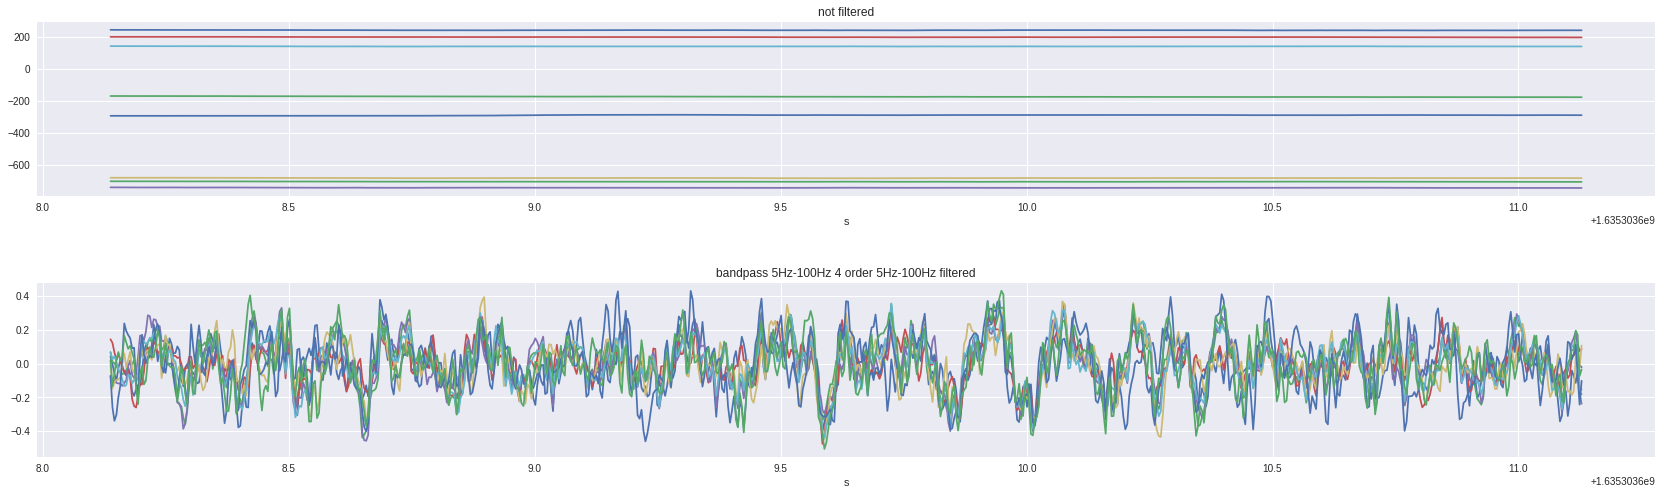

In [ ]:
USE_FILTER = True
frequency_choices = np.unique(one_baseband_data_label)
# bandpass_low = frequency_choices.min() - 10
# bandpass_high = frequency_choices.max() + 10
bandpass_low = 5
bandpass_high = 100
bandpass_order = 4
print(eeg_timeseries.shape)
if USE_FILTER:
  eeg_timeseries_filtered = butter_bandpass_filter(eeg_timeseries, bandpass_low, bandpass_high, 250, order=bandpass_order)
  # eeg_timeseries_filtered = butter_highpass_filter(eeg_timeseries, bandpass_low, 250, order=bandpass_order)
else:
  eeg_timeseries_filtered = eeg_timeseries

channels = [0, 1, 2, 3, 4, 5, 6, 7]
trial_index = 0
fig = plt.figure(figsize=(29, 8))
plt.subplot(2, 1, 1)
plt.plot(eeg_timestamps[one_baseband_data_index_tuple[trial_index][0]: one_baseband_data_index_tuple[trial_index][1]], eeg_timeseries[one_baseband_data_index_tuple[trial_index][0]: one_baseband_data_index_tuple[trial_index][1], channels])
plt.title('not filtered')
plt.xlabel('s')
plt.subplot(2, 1, 2)
plt.plot(eeg_timestamps[one_baseband_data_index_tuple[trial_index][0]: one_baseband_data_index_tuple[trial_index][1]], eeg_timeseries_filtered[one_baseband_data_index_tuple[trial_index][0]: one_baseband_data_index_tuple[trial_index][1], channels])
plt.title(f'bandpass {bandpass_low}Hz-{bandpass_high}Hz {bandpass_order} order {bandpass_low}Hz-{bandpass_high}Hz filtered')
plt.xlabel('s')

fig.subplots_adjust(hspace=0.5)
plt.show()


(104420, 8)


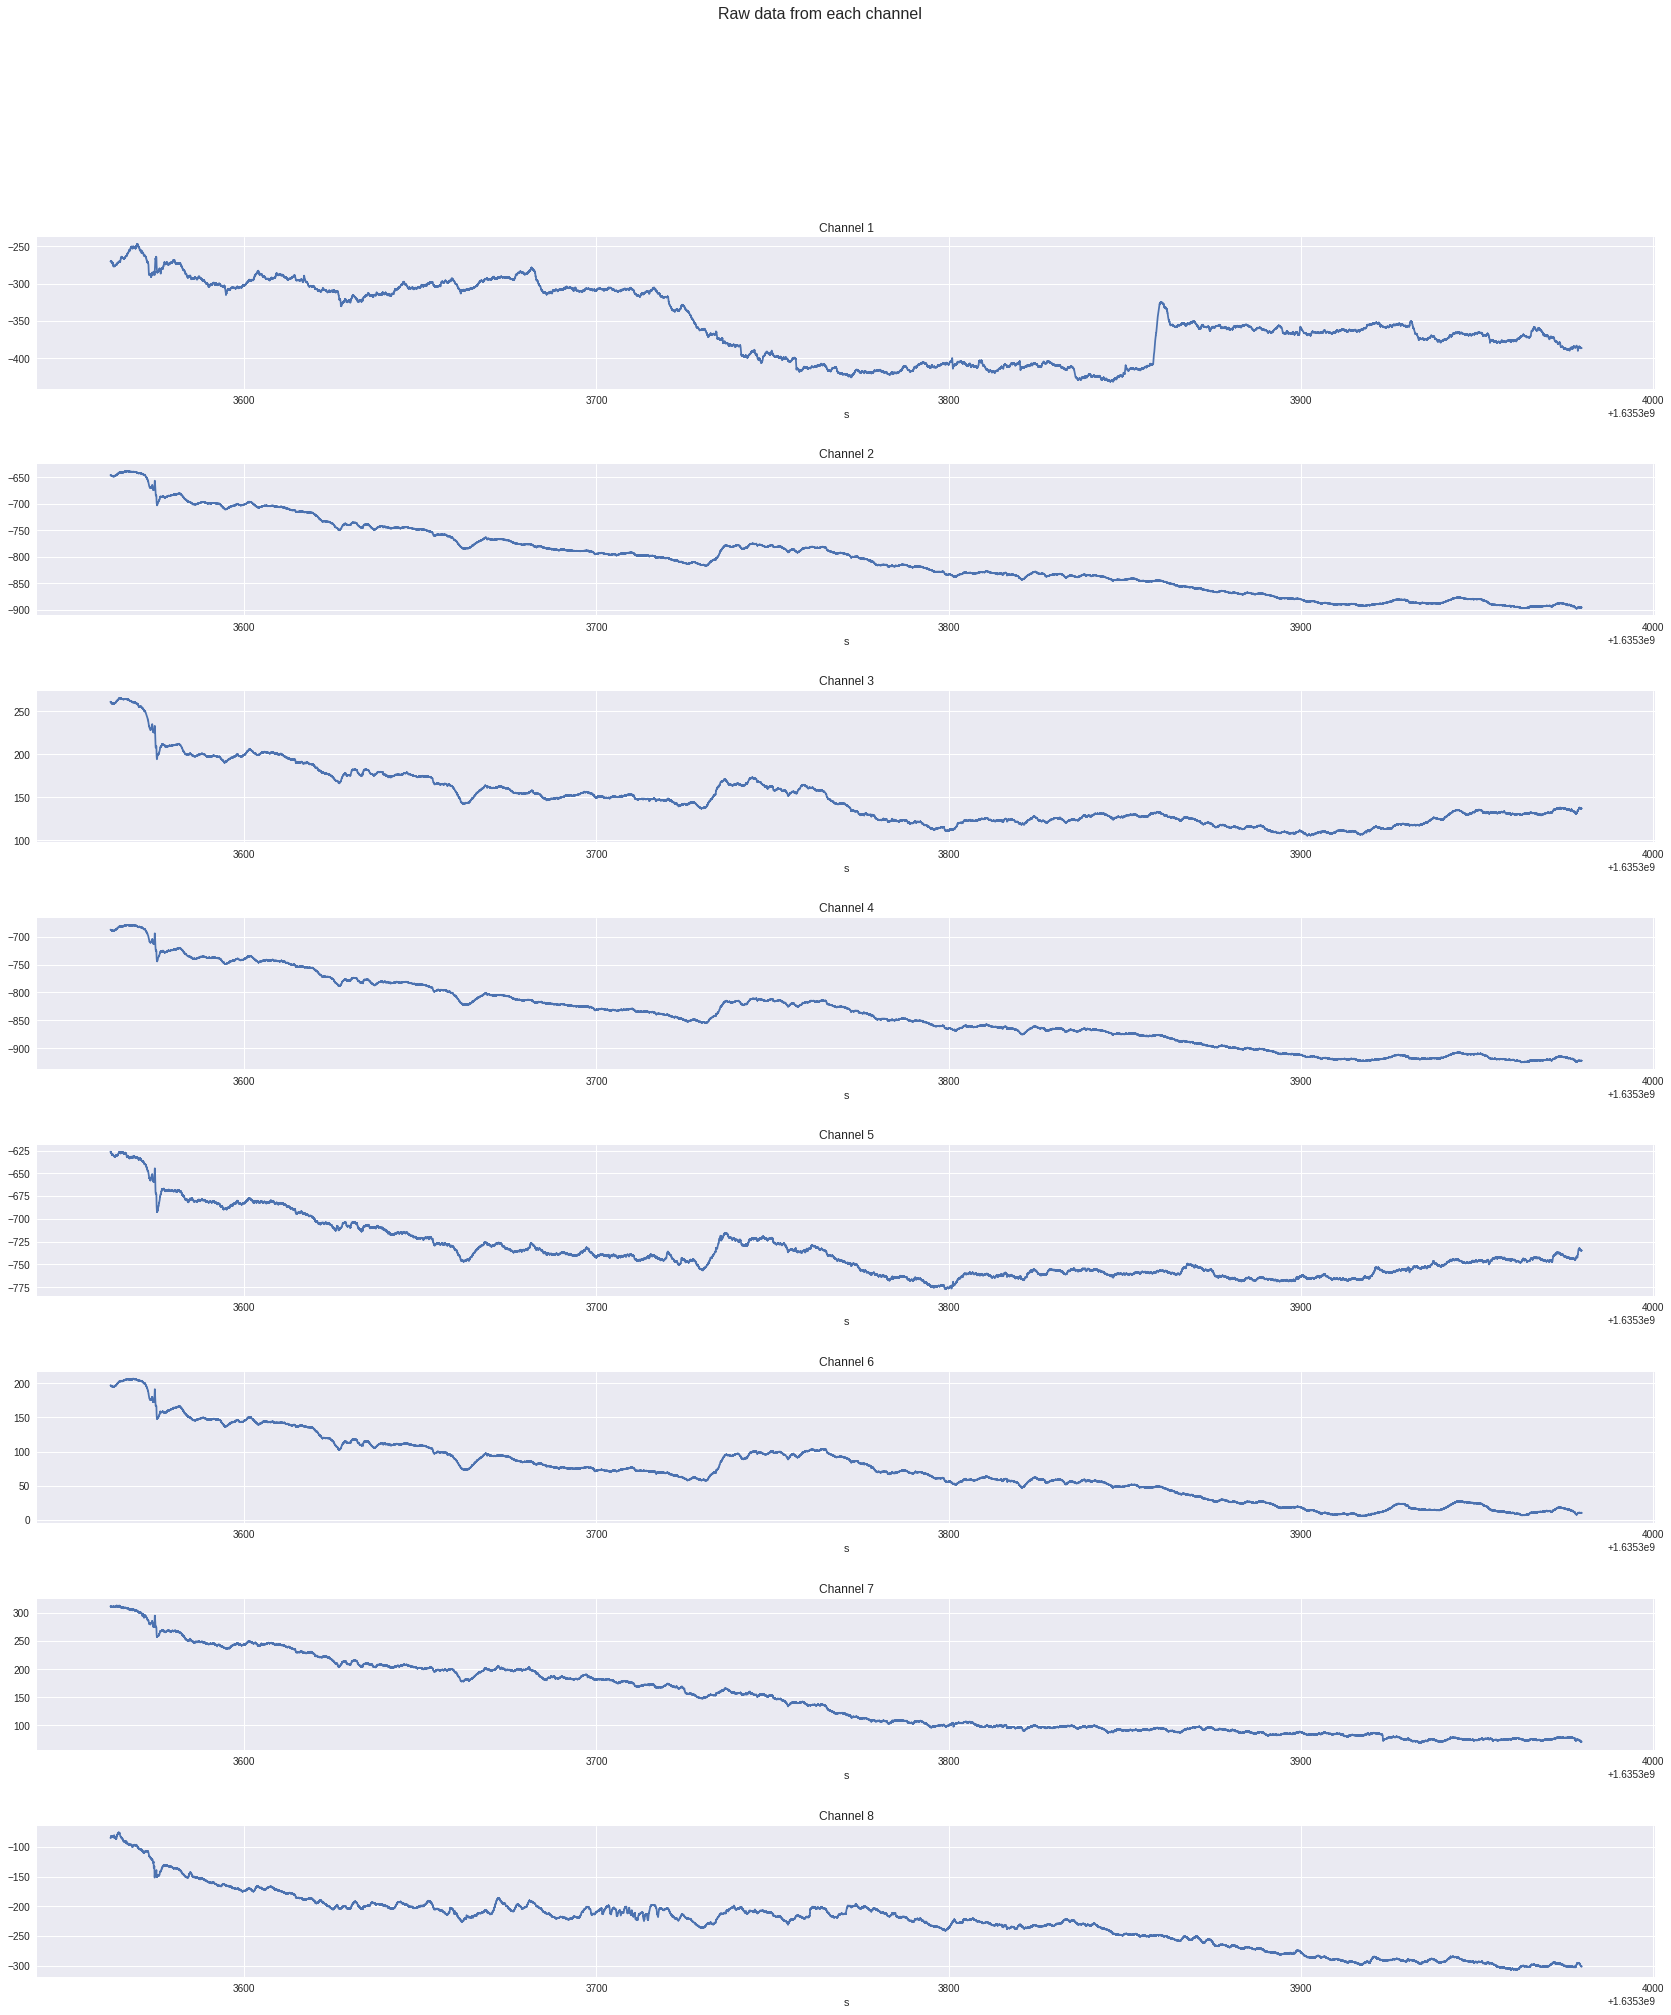

In [ ]:
print(eeg_timeseries.shape)
fig = plt.figure(figsize=(29, 32))
fig.suptitle('Raw data from each channel',fontsize=16)
fig.subplots_adjust(hspace=0.5)
for i in range(eeg_timeseries.shape[1]):
  plt.subplot(8, 1, i+1)
  plt.plot(eeg_timestamps, eeg_timeseries[:, i])
  plt.xlabel('s')
  plt.title(f'Channel {i+1}')

plt.show()

(104420, 8)


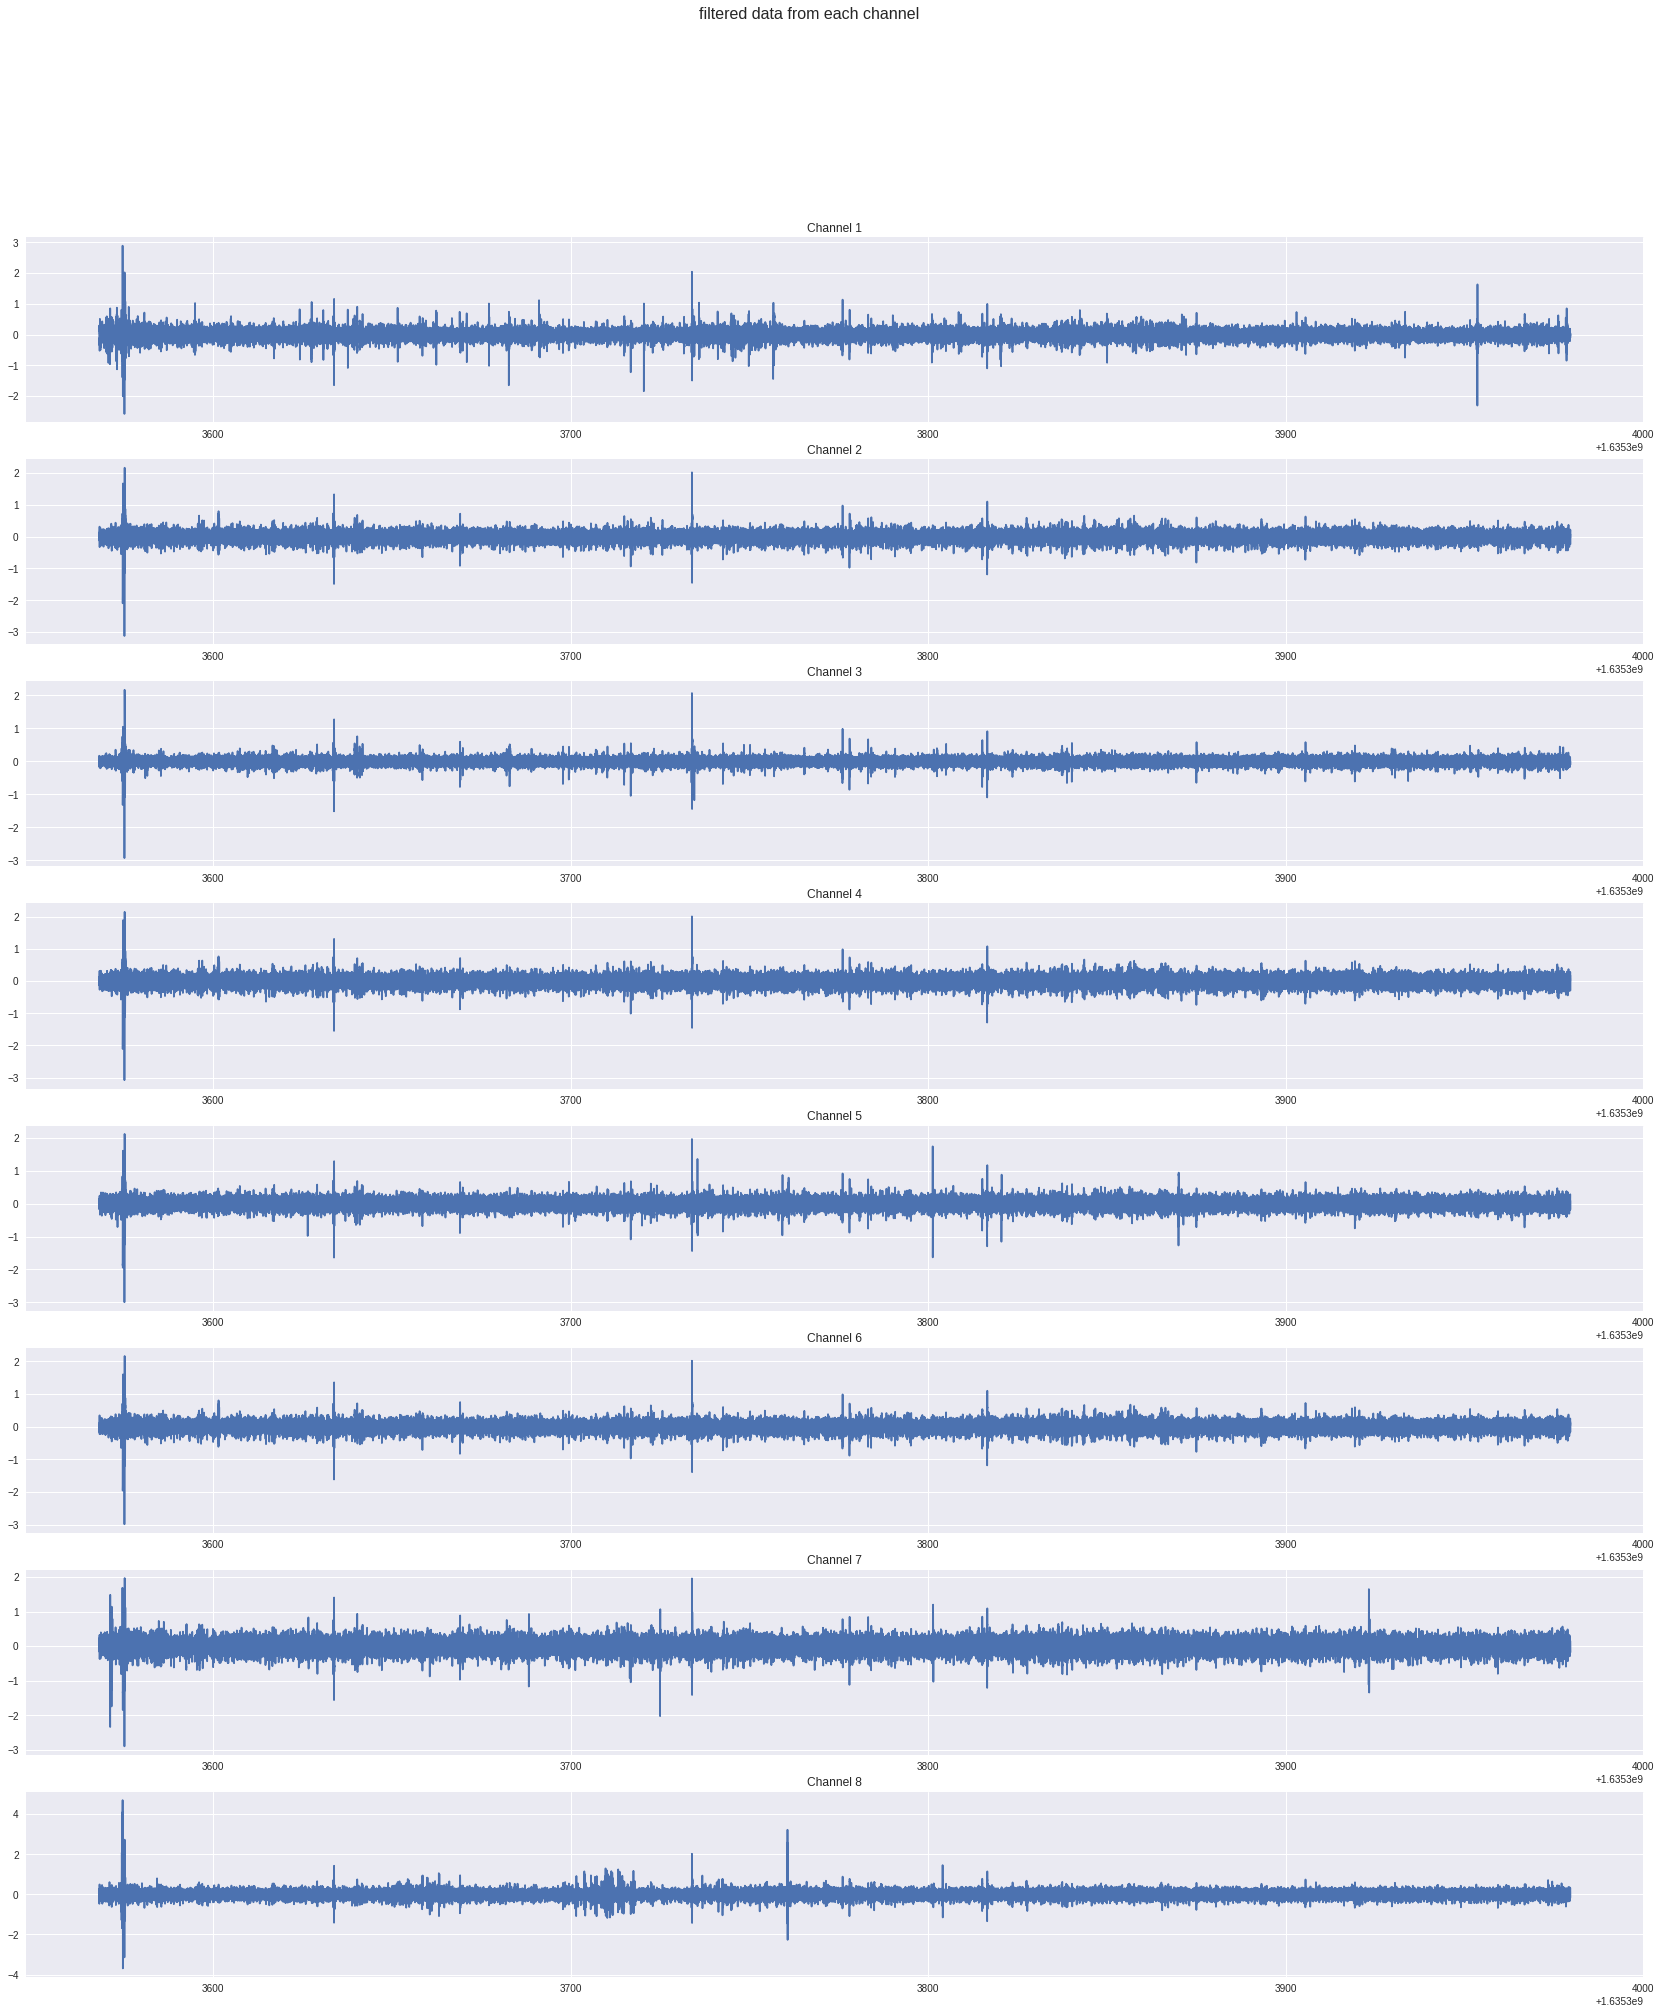

In [ ]:
print(eeg_timeseries_filtered.shape)
fig = plt.figure(figsize=(29, 32))
fig.suptitle('filtered data from each channel',fontsize=16)
for i in range(eeg_timeseries_filtered.shape[1]):
  plt.subplot(8, 1, i+1)
  plt.plot(eeg_timestamps[1500:], eeg_timeseries_filtered[1500:, i])
  plt.title(f'Channel {i+1}')

plt.show()

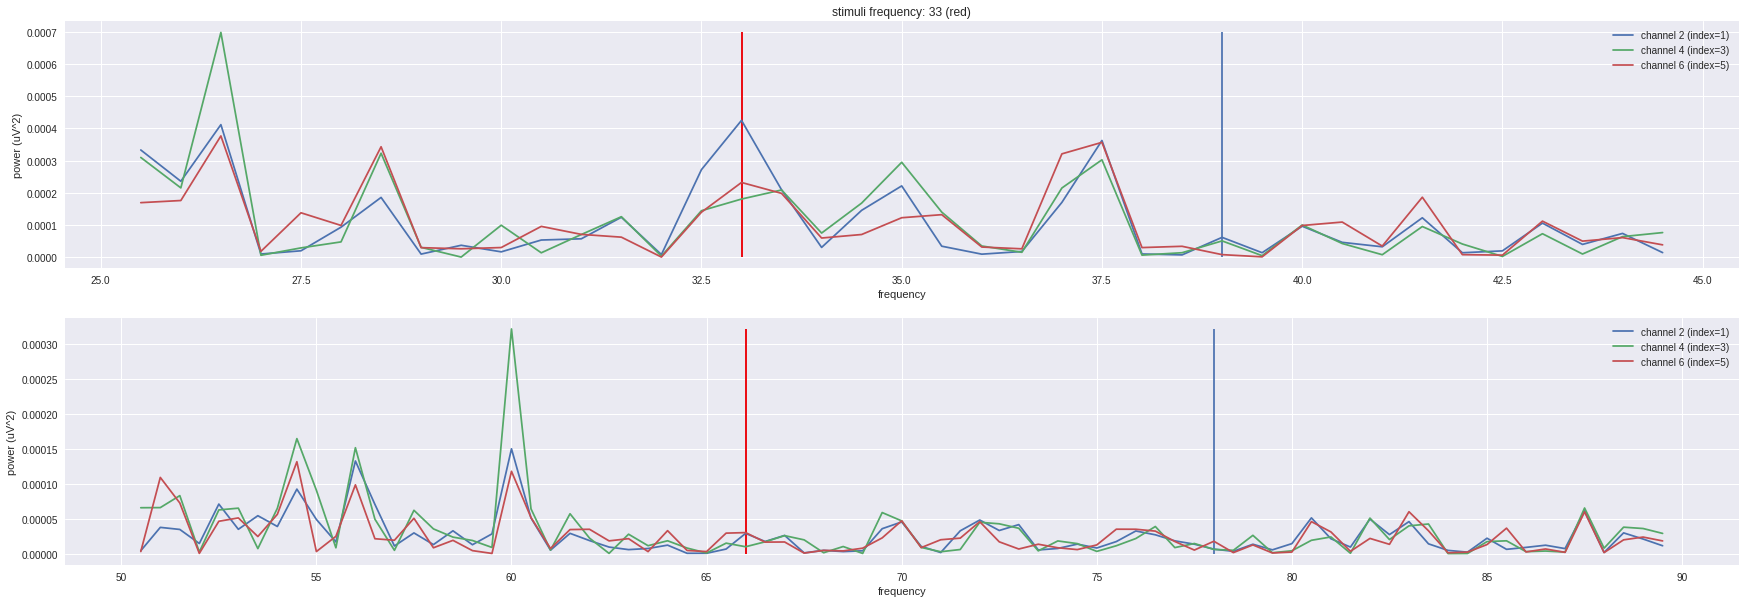

In [ ]:
trial_index = 4
trial_data = eeg_timeseries_filtered[one_baseband_data_index_tuple[trial_index][0]: one_baseband_data_index_tuple[trial_index][1], :]
fft_win = 500
SAMPLE_RATE = 250
DURATION_S = fft_win / 250
DELAY_S = 0.3
DELAY_FRAME = int(SAMPLE_RATE * DELAY_S)
N = fft_win
xf = fftfreq(N, 1 / SAMPLE_RATE)
xf_mask = (xf > 20) & (xf < 80)
selected_xf = xf[xf_mask]
# window = scipy.signal.windows.hamming(fft_win).reshape((fft_win, 1))
# window = scipy.signal.windows.hann(fft_win).reshape((fft_win, 1))
# window = scipy.signal.windows.blackmanharris(fft_win, False).reshape((fft_win, 1))
window = np.ones(fft_win).reshape((fft_win, 1))
# channels=[0, 1, 2, 3, 4, 5, 6, 7]
# channels=[0, 1, 2, 3, 4, 5, 7]
# channels = [0, 1, 2, 3, 4]
# channels=[1, 3]
# channels=[0, 1, 3, 5]
channels=[1, 3, 5]
# channels=[6]
# channels=[6]
fig = plt.figure(figsize=(30, 10))
plt.subplot(2, 1, 1)
xf_mask = (xf > 25) & (xf < 45)
selected_xf = xf[xf_mask]
trial_data = trial_data[DELAY_FRAME: DELAY_FRAME + fft_win, :]
normalize_factor = 2 / fft_win
trial_data_fft = np.power(np.abs(normalize_factor * fft(trial_data[:, channels] * window, axis=0)), 2)
# trial_data_fft = trial_data_fft.mean(axis=1)
# print(trial_data_fft.shape)
# plt.plot(selected_xf, trial_data_fft[xf_mask].mean(axis=1))
plt.plot(selected_xf, trial_data_fft[xf_mask])
plt.vlines(frequency_choices, np.min(trial_data_fft[xf_mask]), np.max(trial_data_fft[xf_mask]))
plt.vlines(one_baseband_data_label[trial_index], np.min(trial_data_fft[xf_mask]), np.max(trial_data_fft[xf_mask]), 'r')
plt.title(f'stimuli frequency: {one_baseband_data_label[trial_index]} (red)')
plt.xlabel('frequency')
plt.ylabel('power (uV^2)')
plt.legend([f'channel {c + 1} (index={c})' for c in channels])

plt.subplot(2, 1, 2)
xf_mask = (xf > 50) & (xf < 90)
selected_xf = xf[xf_mask]
plt.plot(selected_xf, trial_data_fft[xf_mask])
plt.vlines(2 * frequency_choices, np.min(trial_data_fft[xf_mask]), np.max(trial_data_fft[xf_mask]))
plt.vlines(2 * one_baseband_data_label[trial_index], np.min(trial_data_fft[xf_mask]), np.max(trial_data_fft[xf_mask]), 'r')
plt.legend([f'channel {c + 1} (index={c})' for c in channels])
plt.xlabel('frequency')
plt.ylabel('power (uV^2)')

plt.show()

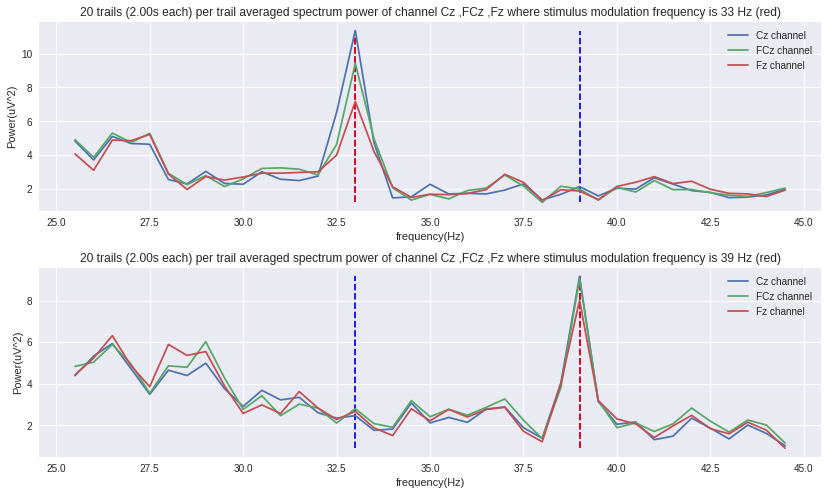

In [ ]:
fft_win = 500
DELAY_S = 0.3
DELAY_FRAME = int(SAMPLE_RATE * DELAY_S)
N = fft_win
xf = fftfreq(N, 1 / SAMPLE_RATE)

# window = scipy.signal.windows.hamming(fft_win).reshape((fft_win, 1))
# window = scipy.signal.windows.hann(fft_win).reshape((fft_win, 1))
# window = scipy.signal.windows.blackmanharris(fft_win, False).reshape((fft_win, 1))
window = np.ones(fft_win).reshape((fft_win, 1))
# channels= np.array([0, 1, 2, 3, 4, 5, 6, 7])
# channels=np.array([0, 1, 3, 5])
# channels=np.array([1, 3, 5])
channel_names = np.array(['T7', 'Cz', 'Tp7', 'FCz', 'Oz', 'Fz', 'Tp8', 'T8'])
channels=np.array([1, 3, 5])
# channels = np.array([0, 1, 2, 3, 4])


# channels = np.array([0, 1, 2, 3, 4])


fig = plt.figure(figsize=(14, 8))
# freq_choices_and_harmonics = np.concatenate((frequency_choices, frequency_choices * 2))
for freq_choice_i, stimuli_freq in enumerate(frequency_choices):
  xf_mask = (xf > 25) & (xf < 45)
  selected_xf = xf[xf_mask]
  stimuli_mask = one_baseband_data_label == stimuli_freq
  # stimuli_mask = (np.arange(len(one_baseband_data_label)) % 2) == freq_choice_i
  stimuli_tuple = np.array([i_tuple for i_tuple, selected in zip(one_baseband_data_index_tuple, stimuli_mask) if selected], dtype='object')
  wins = []
  for start_i, end_i in stimuli_tuple:
    start_i += DELAY_FRAME
    while (start_i + fft_win) < end_i:
      wins.append(eeg_timeseries_filtered[start_i: (start_i + fft_win) , :] * window)
      start_i += fft_win
  normalize_factor = 2 / fft_win
  wins_fft_pow = np.array([np.power(np.abs(normalize_factor * fft(w, axis=0)), 2) for w in wins])
  wins_fft_avg_pow = wins_fft_pow.mean(axis=0)
  # print(wins_fft_avg_pow.shape)
  # plt.subplot(len(frequency_choices), 2, freq_choice_i * 2 + 1)
  plt.subplot(len(frequency_choices), 1, freq_choice_i + 1)
  plt.plot(selected_xf, wins_fft_avg_pow[xf_mask][:, channels])
  v_min, v_max = np.min(wins_fft_avg_pow[xf_mask][:, channels]), np.max(wins_fft_avg_pow[xf_mask][:, channels])
  plt.vlines(frequency_choices, v_min, v_max, 'b', linestyles='dashed')
  plt.vlines(stimuli_freq, v_min, v_max, 'r', linestyles='dashed')
  plt.xlabel('frequency(Hz)')
  plt.ylabel('Power(uV^2)')
  # plt.title(f'{len(wins)} trails ({(fft_win / SAMPLE_RATE):.2f}s each) averaged spectrum power of channel {1 + channels} stimuli modulation frequency: {stimuli_freq} Hz (red)')
  plt.title(f'{len(wins)} trails ({(fft_win / SAMPLE_RATE):.2f}s each) per trail averaged spectrum power of channel {" ,".join(channel_names[channels])} where stimulus modulation frequency is {stimuli_freq} Hz (red)')
  # plt.legend([f'channel {c + 1} (index={c})' for c in channels])
  plt.legend([f'{channel_names[c]} channel' for c in channels])


  # plt.subplot(len(frequency_choices), 2, freq_choice_i * 2 + 2)
  # xf_mask = (xf > 55) & (xf < 85)
  # selected_xf = xf[xf_mask]
  # plt.plot(selected_xf, wins_fft_avg_pow[xf_mask][:, channels])
  # v_min, v_max = np.min(wins_fft_avg_pow[xf_mask][:, channels]), np.max(wins_fft_avg_pow[xf_mask][:, channels])
  # plt.vlines(frequency_choices*2, v_min, v_max, 'b', linestyles='dashed')
  # plt.vlines(stimuli_freq*2, v_min, v_max, 'r', linestyles='dashed')
  # plt.xlabel('frequency(Hz)')
  # plt.ylabel('Power(uV^2)')
  # plt.title(f'{len(wins)} trails ({(fft_win / SAMPLE_RATE):.2f}s each) averaged spectrum power of channel {1 + channels} stimuli baseband frequency 2nd harmonic: {stimuli_freq * 2} Hz (red)')
  # plt.legend([f'channel {c + 1} (index={c})' for c in channels])
  # fig.subplots_adjust(hspace=0.3)

fig.subplots_adjust(hspace=0.3)
plt.show()

[ True False False False  True  True  True  True  True False False  True
 False False  True  True False False False False  True  True  True False
 False  True  True False  True False  True False False  True False  True
  True False False  True]
[False  True  True  True False False False False False  True  True False
  True  True False False  True  True  True  True False False False  True
  True False False  True False  True False  True  True False  True False
 False  True  True False]


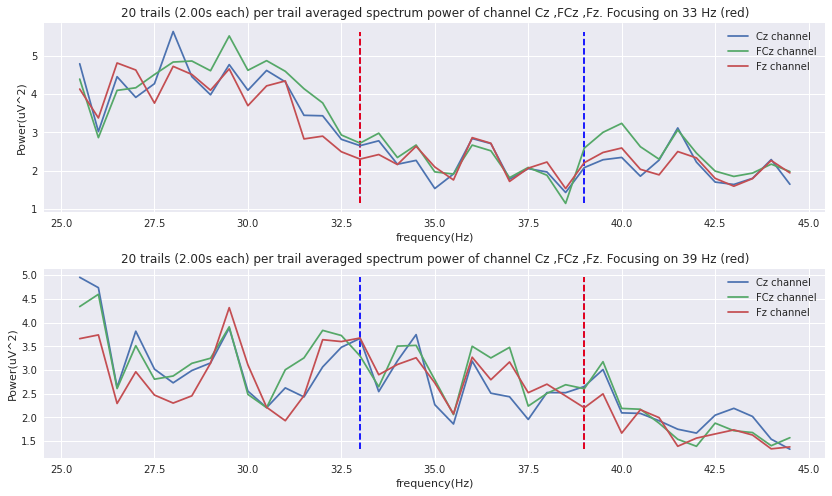

In [ ]:
fft_win = 500
DELAY_S = 0.2
DELAY_FRAME = int(SAMPLE_RATE * DELAY_S)
N = fft_win
xf = fftfreq(N, 1 / SAMPLE_RATE)

# window = scipy.signal.windows.hamming(fft_win).reshape((fft_win, 1))
window = scipy.signal.windows.hann(fft_win).reshape((fft_win, 1))
# window = scipy.signal.windows.blackmanharris(fft_win, False).reshape((fft_win, 1))
# window = np.ones(fft_win).reshape((fft_win, 1))
# channels= np.array([0, 1, 2, 3, 4, 5, 6, 7])
channels= np.array([1, 3, 5])
# channels= np.array([1, 3])
# channels = np.array([0, 1, 2, 3])
# channels= np.array([2, 4, 6, 7])

# channels=np.array([1, 3])

fig = plt.figure(figsize=(14, 8))
# freq_choices_and_harmonics = np.concatenate((frequency_choices, frequency_choices * 2))
for freq_choice_i, stimuli_freq in enumerate(frequency_choices):
  xf_mask = (xf > 25) & (xf < 45)
  selected_xf = xf[xf_mask]
  concentration_mask = two_baseband_data_focus_label == stimuli_freq
  print(concentration_mask)
  # two_baseband_data_index_tuple

  stimuli_tuple = np.array([i_tuple for i_tuple, selected in zip(two_baseband_data_index_tuple, concentration_mask) if selected], dtype='object')
  wins = []
  for start_i, end_i in stimuli_tuple:
    start_i += DELAY_FRAME
    while (start_i + fft_win) < end_i:
      wins.append(eeg_timeseries_filtered[start_i: (start_i + fft_win) , :] * window)
      start_i += fft_win
  
  wins_fft_pow = np.array([np.power(np.abs(fft(w, axis=0)), 2) for w in wins])
  wins_fft_avg_pow = wins_fft_pow.mean(axis=0)
  # print(wins_fft_avg_pow.shape)
  # plt.subplot(len(frequency_choices), 2, freq_choice_i * 2 + 1)
  plt.subplot(len(frequency_choices), 1, freq_choice_i + 1)
  plt.plot(selected_xf, wins_fft_avg_pow[xf_mask][:, channels])
  v_min, v_max = np.min(wins_fft_avg_pow[xf_mask][:, channels]), np.max(wins_fft_avg_pow[xf_mask][:, channels])
  plt.vlines(frequency_choices, v_min, v_max, 'b', linestyles='dashed')
  plt.vlines(stimuli_freq, v_min, v_max, 'r', linestyles='dashed')
  plt.xlabel('frequency(Hz)')
  plt.ylabel('Power(uV^2)')
  # plt.title(f'{len(wins)} trails ({(fft_win / SAMPLE_RATE):.2f}s each) averaged spectrum power of channel {1 + channels}, frequency presented:{frequency_choices} Hz focus on frequency: {stimuli_freq} Hz (red)')
  # plt.legend([f'channel {c + 1} (index={c})' for c in channels])
  plt.title(f'{len(wins)} trails ({(fft_win / SAMPLE_RATE):.2f}s each) per trail averaged spectrum power of channel {" ,".join(channel_names[channels])}. Focusing on {stimuli_freq} Hz (red)')
  plt.legend([f'{channel_names[c]} channel' for c in channels])
fig.subplots_adjust(hspace=0.3)
plt.show()

## Do some crazy test to see if there is any blood signal

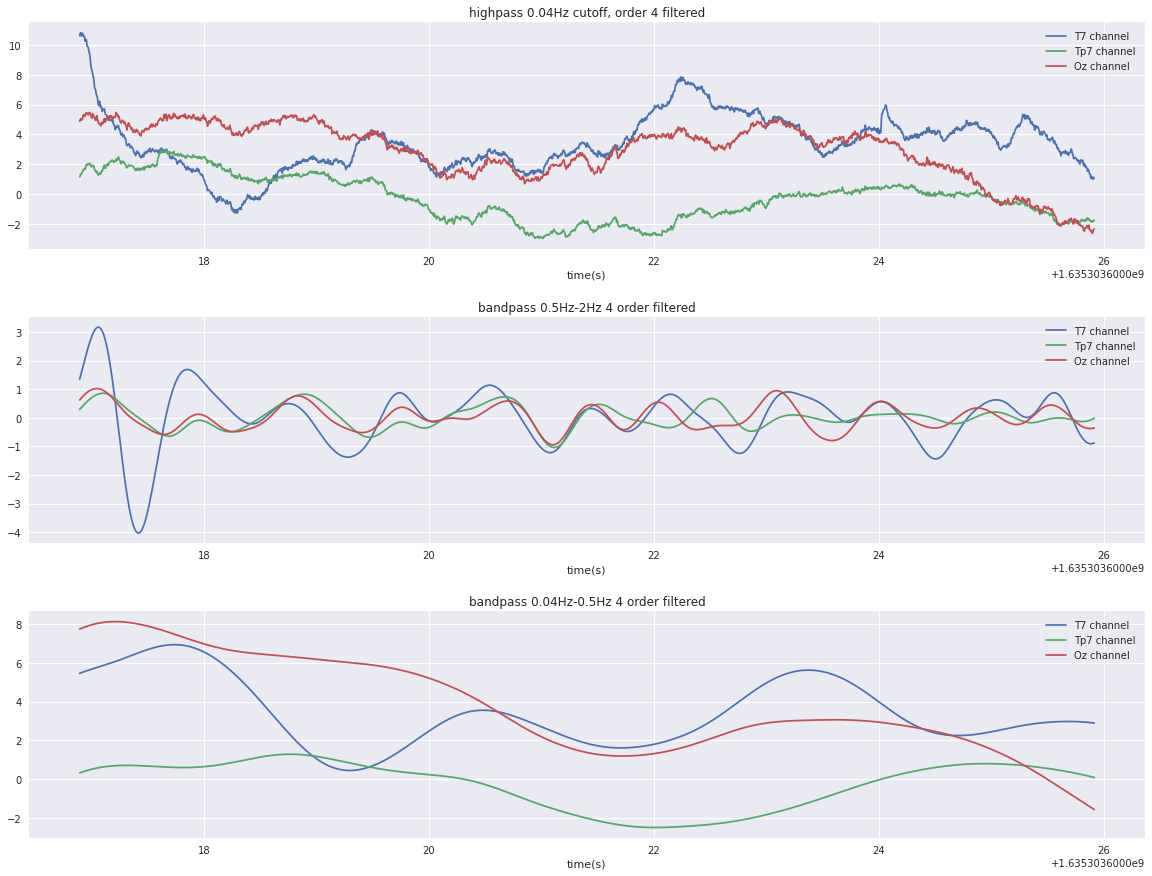

In [ ]:
highpass_cut = 0.04
highpass_order = 4
eeg_timeseries_highpass = butter_highpass_filter(eeg_timeseries, highpass_cut, fs=250, axis=0, order=highpass_order)


card_bandpass_low = 0.5
card_bandpass_high = 2
card_bandpass_order = 4
eeg_timeseries_filtered_for_card = butter_bandpass_filter(eeg_timeseries, card_bandpass_low, card_bandpass_high, 250, order=card_bandpass_order)

bold_bandpass_low = 0.04
bold_bandpass_high = 0.5
bold_bandpass_order = 4
eeg_timeseries_filtered_for_bold = butter_bandpass_filter(eeg_timeseries, bold_bandpass_low, bold_bandpass_high, 250, order=bold_bandpass_order)

# channels = [0, 1, 2, 3, 4, 5, 6, 7]
# channels = [1, 3, 5]
channels = [0, 2 ,4]
# channels = [4, 6, 7]
trial_index = 1
fig = plt.figure(figsize=(20, 15))
plt.subplot(3, 1, 1)
plt.plot(eeg_timestamps[one_baseband_data_index_tuple[trial_index][0]: one_baseband_data_index_tuple[trial_index + 1][0]], eeg_timeseries_highpass[one_baseband_data_index_tuple[trial_index][0]: one_baseband_data_index_tuple[trial_index + 1][0], channels])
plt.title(f'highpass {highpass_cut}Hz cutoff, order {highpass_order} filtered')
plt.xlabel('time(s)')
plt.legend([f'{channel_names[c]} channel' for c in channels])

plt.subplot(3, 1, 2)
plt.plot(eeg_timestamps[one_baseband_data_index_tuple[trial_index][0]: one_baseband_data_index_tuple[trial_index + 1][0]], eeg_timeseries_filtered_for_card[one_baseband_data_index_tuple[trial_index][0]: one_baseband_data_index_tuple[trial_index + 1][0], channels])
plt.title(f'bandpass {card_bandpass_low}Hz-{card_bandpass_high}Hz {card_bandpass_order} order filtered')
plt.xlabel('time(s)')
plt.legend([f'{channel_names[c]} channel' for c in channels])


plt.subplot(3, 1, 3)
plt.plot(eeg_timestamps[one_baseband_data_index_tuple[trial_index][0]: one_baseband_data_index_tuple[trial_index + 1][0]], eeg_timeseries_filtered_for_bold[one_baseband_data_index_tuple[trial_index][0]: one_baseband_data_index_tuple[trial_index + 1][0], channels])
plt.title(f'bandpass {bold_bandpass_low}Hz-{bold_bandpass_high}Hz {bold_bandpass_order} order filtered')
plt.xlabel('time(s)')
plt.legend([f'{channel_names[c]} channel' for c in channels])

fig.subplots_adjust(hspace=0.3)
plt.show()



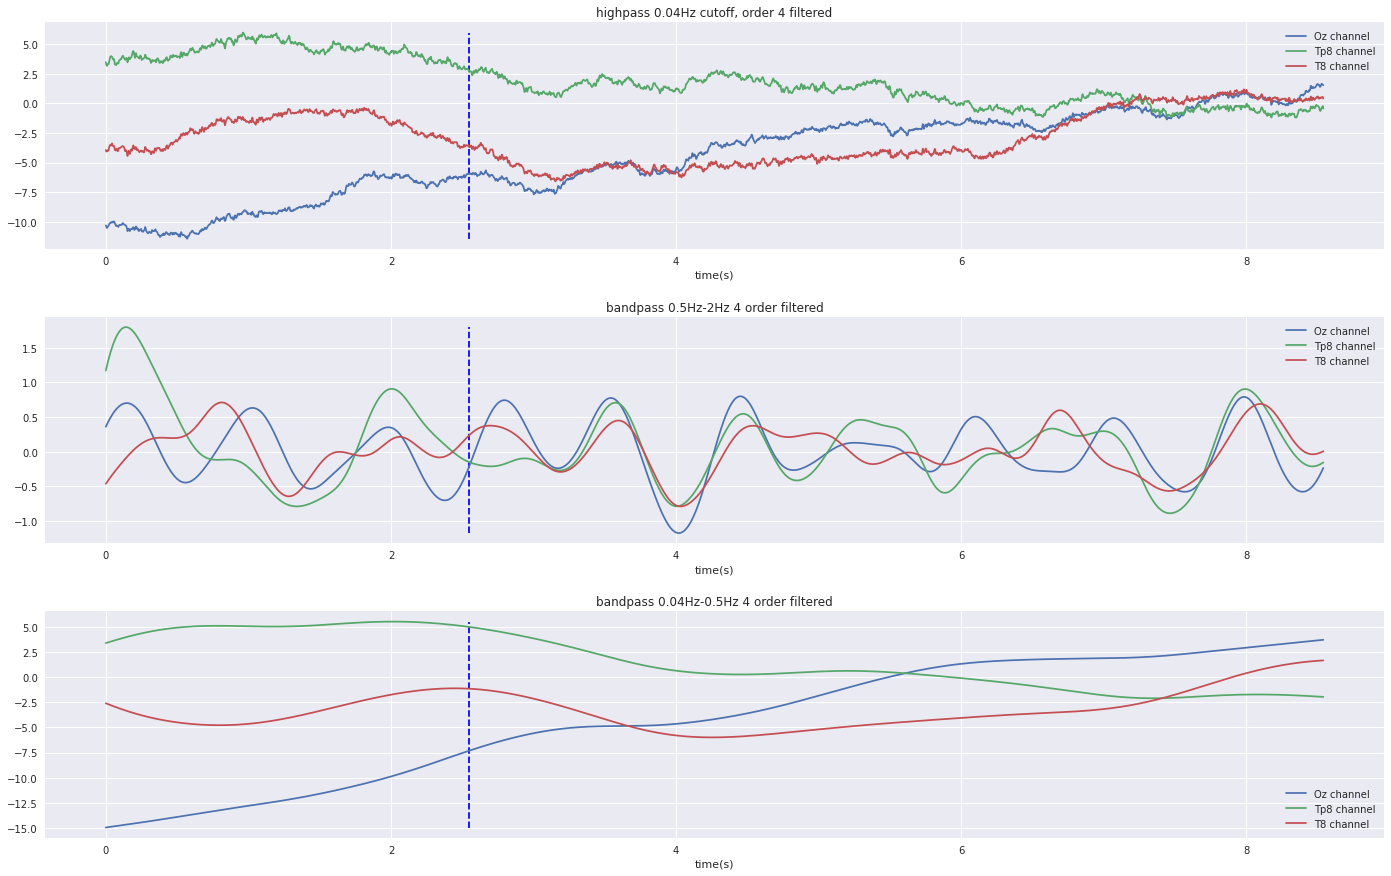

In [ ]:

start_i = quiet_period_data_index_tuple[1]
end_i = one_baseband_data_index_tuple[0][1] + 3 * SAMPLE_RATE
stimuli_start = one_baseband_data_index_tuple[0][0]

# channels = [0, 1, 2, 3, 4, 5, 6, 7]
# channels = [1, 3, 5]
# channels = [0, 2 ,4]
channels = [4, 6, 7]
fig = plt.figure(figsize=(24, 15))
plt.subplot(3, 1, 1)
v_min =  np.min(eeg_timeseries_highpass[start_i: end_i, channels])
v_max =  np.max(eeg_timeseries_highpass[start_i: end_i, channels])
plt.plot(eeg_timestamps[start_i: end_i] - eeg_timestamps[start_i], eeg_timeseries_highpass[start_i: end_i, channels])
plt.vlines([eeg_timestamps[stimuli_start] - eeg_timestamps[start_i]] , v_min, v_max, 'b', linestyles='dashed')
plt.title(f'highpass {highpass_cut}Hz cutoff, order {highpass_order} filtered')
plt.xlabel('time(s)')
plt.legend([f'{channel_names[c]} channel' for c in channels])

plt.subplot(3, 1, 2)
v_min =  np.min(eeg_timeseries_filtered_for_card[start_i: end_i, channels])
v_max =  np.max(eeg_timeseries_filtered_for_card[start_i: end_i, channels])
plt.plot(eeg_timestamps[start_i: end_i] - eeg_timestamps[start_i], eeg_timeseries_filtered_for_card[start_i: end_i, channels])
plt.title(f'bandpass {card_bandpass_low}Hz-{card_bandpass_high}Hz {card_bandpass_order} order filtered')
plt.xlabel('time(s)')
plt.legend([f'{channel_names[c]} channel' for c in channels])
plt.vlines([eeg_timestamps[stimuli_start] - eeg_timestamps[start_i]] , v_min, v_max, 'b', linestyles='dashed')


plt.subplot(3, 1, 3)
v_min =  np.min(eeg_timeseries_filtered_for_bold[start_i: end_i, channels])
v_max =  np.max(eeg_timeseries_filtered_for_bold[start_i: end_i, channels])
plt.plot(eeg_timestamps[start_i: end_i] - eeg_timestamps[start_i], eeg_timeseries_filtered_for_bold[start_i: end_i, channels])
plt.title(f'bandpass {bold_bandpass_low}Hz-{bold_bandpass_high}Hz {bold_bandpass_order} order filtered')
plt.xlabel('time(s)')
plt.legend([f'{channel_names[c]} channel' for c in channels])
plt.vlines([eeg_timestamps[stimuli_start] - eeg_timestamps[start_i]] , v_min, v_max, 'b', linestyles='dashed')

fig.subplots_adjust(hspace=0.3)
plt.show()

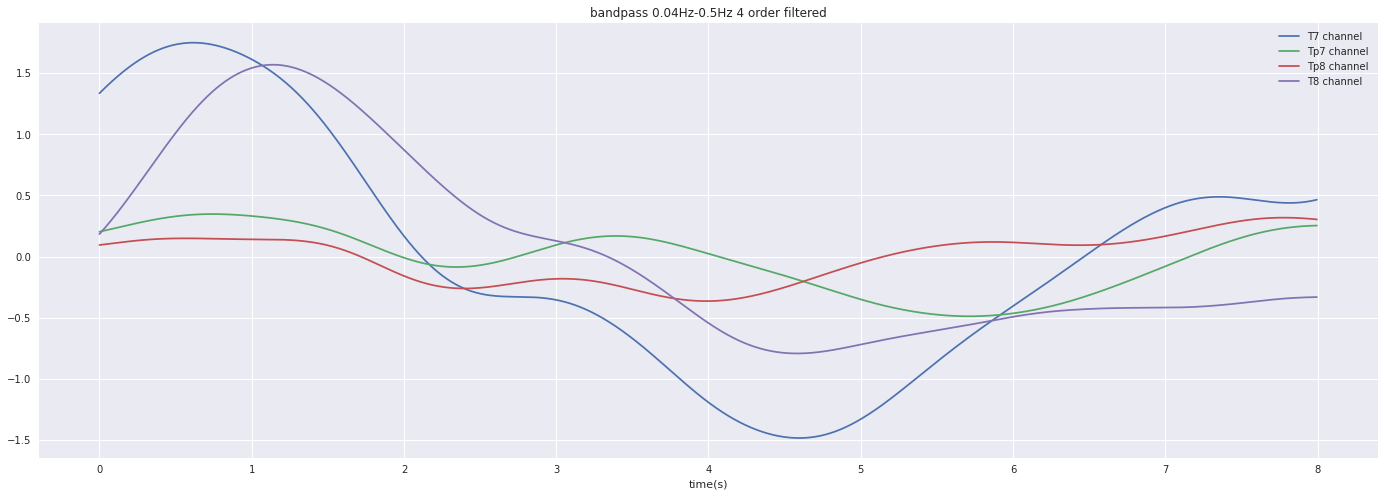

In [ ]:
start_offset = SAMPLE_RATE
# channels = [0, 1, 2, 3, 4, 5, 6, 7]
# channels = [1, 3, 5]
# channels = [0, 2]
# channels = [6, 7]
channels = [0, 2, 6, 7]
# channels = [7]
end_offset_s = 8
end_offset = SAMPLE_RATE * end_offset_s
one_baseband_data_index_tuple_expanded = [(start, start + end_offset) for start, end in one_baseband_data_index_tuple]
sliced_bold_data = np.array([eeg_timeseries_filtered_for_bold[start:end, :] for start, end in one_baseband_data_index_tuple_expanded])
sliced_bold_data_avg = sliced_bold_data.mean(axis=0)
sliced_bold_data_std = sliced_bold_data.std(axis=0)
timestamps = np.linspace(0, end_offset_s, sliced_bold_data.shape[1], endpoint=False)
fig = plt.figure(figsize=(24, 8))
plt.plot(timestamps, sliced_bold_data_avg[:, channels])
if len(channels) == 1:
  plt.plot(timestamps, sliced_bold_data_avg[:, channels] + sliced_bold_data_std[:,channels])
  plt.plot(timestamps, sliced_bold_data_avg[:, channels] - sliced_bold_data_std[:,channels])
plt.title(f'bandpass {bold_bandpass_low}Hz-{bold_bandpass_high}Hz {bold_bandpass_order} order filtered')
plt.xlabel('time(s)')
plt.legend([f'{channel_names[c]} channel' for c in channels])
plt.show()